# Transform module of `mlcolvar`
 
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/adv_transforms.ipynb)

Author: Enrico Trizio

In this noteboook, we will provide an overview of the `transform` module of the library.
This includes non-trainable modules based on a parent `transform` class and divided into two groups:
- `descriptors`: physical descriptors that can be computed from **atomic positions**, including, for example:
    - `PairwiseDistances`
    - `TorsionalAngles`
    - `CoordinationNumbers`
     
    Multiple descriptors can also be combined using the `MultipleDescriptors` class.
- `tools`: processing tools and utilities, including, for example:
    - `Normalization`
    - `SwitchingFunctions`
    - `ContinuousHistogram`

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from mlcolvar.utils.io import load_dataframe

## Computing descriptors with `mlcolvar`


All the descriptors classes share some general features:

**Positions as input**

Descriptors in `mlcolvar` take atomic positions as inputs. These can be also returned by `PLUMED` using the `POSITION` keyword for a simpler loading through colvar files.
The positions can be used both as absolute coordinates (default) or as coordinates scaled on the cell's vectors. In this case, the `scaled_coords` key should be set to `True`. 

**Cell and PBC**

Currently, PBC are implemented **only for orthorombic simulation cells**. By default, PBC are enabled, and the cell's dimensions have to be provided through the `cell` keyword 

**Combining descriptors**

Multiple descriptors computed on the same set of positions (eventually of a diffent type) can be combined into a single transform object using `MultipleDescriptors`. For example, we can combine some torsional angles with some distances.

Here we use alanine dipeptide as an example and we will first show how to compute the single decriptors and then how they can be combined.

In [2]:
# number of atoms
n_atoms=10

# simulation cell 
cell = torch.Tensor([3.0233, 3.0233, 3.0233])

 
filenames = ['https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/unbiased_sims/COLVAR_A',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/unbiased_sims/COLVAR_B',
            ]           

# load data
dataframe = load_dataframe(file_names = filenames,
                            create_labels = True,
                            return_dataframe = True,
                            start=0,
                            stop=10000,
                            stride=10,
                            verbose = True)

# we put the positions into a tensor
positions = torch.Tensor(dataframe.filter(regex='p[1-9]\.[abc]|p[1-2][0-9]\.[abc]').values) 

### TorsionalAngles
Torsional angles can be computed using the `TorsionalAngles` class, which can return the sin, cos and angle value based on the `mode` key.

Here we compute the sin and cos of the usual $\phi$ and $\psi$ angles of alanine.

In [ ]:
from mlcolvar.core.transform.descriptors import TorsionalAngle

# initialize objects to compute angles
# this computes the sin and cos of Phi, to return also the angle add 'angle' to the mode list.
ComputePhi = TorsionalAngle(indices=[1,3,4,6],
                                n_atoms=10,
                                mode=['sin', 'cos'],
                                PBC=True, 
                                cell=cell, 
                                scaled_coords=True)

# this computes the sin and cos of Psi to return also the angle add 'angle' to the mode list.
ComputePsi = TorsionalAngle(indices=[3,4,6,8],
                                n_atoms=10,
                                mode=['sin', 'cos'], 
                                PBC=True, 
                                cell=cell, 
                                scaled_coords=True)

# we apply it on the input positions
out_phi = ComputePhi(positions)
out_psi = ComputePsi(positions)

print(out_phi.shape)
print(out_psi.shape)


torch.Size([2000, 2])
torch.Size([2000, 2])


Alternatively, a list of indices can be given to compute multiple torsional angles all at once.

In [ ]:
# initialize objects to compute angles
# this computes the sin and cos of Phi, to return also the angle add 'angle' to the mode list.
ComputeAngles = TorsionalAngle(indices=[[1,3,4,6],
                                         [3,4,6,8]],
                                n_atoms=10,
                                mode=['sin', 'cos'],
                                PBC=True, 
                                cell=cell, 
                                scaled_coords=True)

# we apply it on the input positions
out_angles = ComputeAngles(positions)

print(out_angles.shape)

# check that we got consistent results
print(torch.allclose(out_phi, out_angles[:, :2]))
print(torch.allclose(out_psi, out_angles[:, 2:]))

torch.Size([2000, 4])
True
True


### PairwiseDistances
Pairwise distances can be computed using the `PairwiseDistances` class, which, by default, computes all the non-duplicated distances between the given atoms. Otherwise, if we are interested in some specific distances only we can choose the corresponing atomic paris using the `slicing_pairs` keyword.   

In [8]:
from mlcolvar.core.transform.descriptors import PairwiseDistances

# compute ALL the non duplicated distances within the given set of atoms
# initialize object to compute all distances
ComputeDistances = PairwiseDistances(n_atoms=10, 
                                     PBC=True, 
                                     cell=cell, 
                                     scaled_coords=True)

# we apply it to the positions
out_dist = ComputeDistances(positions)

print(out_dist.shape)

# compute only some specific distances within the given set of atoms
# initialize object to compute distances between atom pairs: 0:1 2:3 4:5
ComputeDistances_red = PairwiseDistances(n_atoms=10, 
                                         PBC=True, 
                                         cell=cell, 
                                         scaled_coords=True,
                                         slicing_pairs=[[0, 1],
                                                        [2, 3],
                                                        [4, 5],])

# we apply it to the positions
out_dist_red = ComputeDistances_red(positions)

print(out_dist_red.shape)

torch.Size([2000, 45])
torch.Size([2000, 3])


### CoordinationNumbers
The coordination number of a group A of atoms with respect to those from a group B based on a cutoff radius can be computed using the `CoordinationNumbers` class.
the overall behaviour of this class mimics the one of `COORDINATION` in `PLUMED`.

In [9]:
from mlcolvar.core.transform.descriptors import CoordinationNumbers
from mlcolvar.core.transform.tools import SwitchingFunctions

# to make the coordiantion numbers derivable we need to apply a switching function for the cutoff
# more details are given below
# here it's important to note that the optional dmax ensures that at cutoff the switch value is zero, similarly to PLUMED
switching_function = SwitchingFunctions(in_features=10*3, # n_atoms*3
                                        name='Rational',
                                        cutoff=0.1,
                                        dmax=0.1,
                                        options={'n': 6, 'm': 12}
                                        )

# compute the coordination of atoms 0 and 9 with respect to the others
ComputeCoord = CoordinationNumbers(group_A=[0, 9],
                                   group_B=[1,2,3,4,5,6,7,8],
                                   cutoff=0.1, 
                                   n_atoms=10, 
                                   PBC=True, 
                                   cell=cell,
                                   mode='continuous',   # there's also a discontinuous mode with a sharp cutoff that is not derivable but can be used for analysis
                                   switching_function=switching_function,
                                   dmax=0.1
                                  )

# we apply it to the positions
out_coord = ComputeCoord(positions)

print(out_coord.shape)


torch.Size([2000, 2])


## Combining descriptors with `mlcolvar`


Multiple and different descriptors acting on the same positions can be combine using the `MultipleDescriptors` class, which takes a list of descriptor objects and combines them into a single model.

In [10]:
from mlcolvar.core.transform.descriptors import MultipleDescriptors

# we combine the descriptors
ComputeDescriptors = MultipleDescriptors(descriptors_list=[ComputePhi,      # two outputs     
                                                           ComputePsi,      # two outputs
                                                           ComputeDistances # three outputs
                                                           ], 
                                         n_atoms=n_atoms)

# we applied the combined model to the input positions
out_combined = ComputeDescriptors(positions)

print(out_combined.shape)


torch.Size([2000, 49])


## Processing tools in `mlcolvar`

The transform objects in `tools` are used for general processing of data.
Here we'll see two examples:
- `SwitchingFunctions`, which can be used, for example, to define contacts from distances
- `ContinuousHistograms`, which can be used, for example, to build differentiable CVs related to the distribution of some input. 
 

### SwitchingFunctions
Switching functions can be used to *switch* some input above and below a threshold and are avaialble using the `SwitchingFunction` class.

For example, we can use this to turn our distances into contacts, which may be more suitable to describe the on/off nature of chemical reactions.

In [11]:
from mlcolvar.core.transform.tools import SwitchingFunctions

# initialize object to compute switching function
ComputeSwitch = SwitchingFunctions(in_features=45,
                                    name='Rational',
                                    cutoff=0.3,
                                    options={'n': 6, 'm': 12})

# we apply to the distances
out_contacts = ComputeSwitch(out_dist)

print(out_contacts.shape)

torch.Size([2000, 45])


### ContinuousHistogram

Continuous histograms can be computed using the `ContinuousHistogram` class, which allows constructing differentiable histograms using Gaussian kernels returning the values of the bins.

We can test this on the distances and contacts in our system

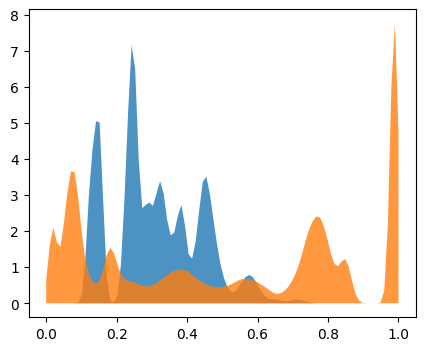

In [12]:
from mlcolvar.core.transform.tools import ContinuousHistogram

# we initialize the object for the histogram computation 
ComputeHistogram = ContinuousHistogram(in_features=45,
                                       min=0,
                                       max=1, 
                                       bins=100)

# we apply it to the distances
out_hist_dist = ComputeHistogram(out_dist)
# we apply it to the contacts
out_hist_contacts = ComputeHistogram(out_contacts)

# we compare the two distributions
plt.figure(figsize=(5,4))
plt.fill_between(np.linspace(0, 1, 100), 0, out_hist_dist.mean(axis=0), alpha=0.8)
plt.fill_between(np.linspace(0, 1, 100), 0, out_hist_contacts.mean(axis=0), alpha=0.8)
plt.show()

## Sequentially apply transforms in `mlcolvar` 
To apply sequentially different transforms we can simply use a `torch.nn.Sequential` class.

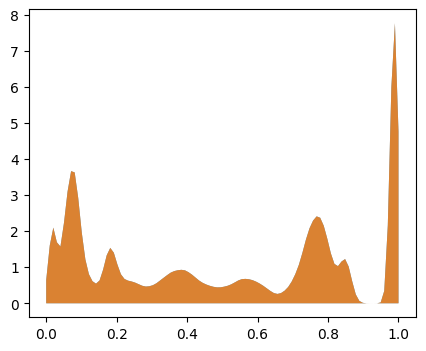

In [13]:
ComputeContactsHist = torch.nn.Sequential(ComputeDistances, ComputeSwitch, ComputeHistogram)

# we initialize the object for the computation positions -> distances -> contacts -> histogram
out_sequential = ComputeContactsHist(positions)

# we compare the two distributions
plt.figure(figsize=(5,4))
plt.fill_between(np.linspace(0, 1, 100), 0, out_sequential.mean(axis=0), alpha=0.8)
plt.fill_between(np.linspace(0, 1, 100), 0, out_hist_contacts.mean(axis=0), alpha=0.8)
plt.show()
